In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as so
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import LogNorm
import TransformCoords

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
def find_confidence_interval(x, pdf, confidence_level, area, sigma_string):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, xbins2d,ybins2d, ax=None,pred = True, **contour_kwargs):
    
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=[xbins2d,ybins2d], range = [[xbins2d.min(),xbins2d.max()],[ybins2d.min(),ybins2d.max()]],density=True)
    xcenters = (xedges[1:]+ xedges[:-1])/2
    ycenters = (yedges[1:]+ yedges[:-1])/2
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,len(xcenters)))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((len(ycenters),1))
    area = (x_bin_sizes*y_bin_sizes)
    #print(area)
    pdf = (H*(x_bin_sizes*y_bin_sizes))
    # 0.39346934, 0.67534753, 0.86466472
    low_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.15, area,'low_sigma'))
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.39, area,'one_sigma'))
    med_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.66, area,'med_sigma'))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.86, area,'two_sigma'))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99, area,'three_sigma'))
    levels = [three_sigma, two_sigma, med_sigma, one_sigma, low_sigma]
    levels_plot = [three_sigma, two_sigma,one_sigma]
    #print(levels)
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    print(np.shape(Z))

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels_plot, origin="lower", **contour_kwargs)
    else:
        if pred == True:
            contour = ax.contour(X, Y, Z, levels=levels_plot, origin="lower", colors = ['maroon','red','salmon'],  **contour_kwargs)
            #p1 = contour.collections[0].get_paths()
            #coor_p1 = p1[-1].vertices
        if pred == False:
            contour = ax.contour(X, Y, Z, levels=levels_plot, origin="lower", colors = ['darkblue','blue','deepskyblue'],  **contour_kwargs)
    return contour, levels, Z

def density_contour_MC(H, xedges, yedges, xbins2d,ybins2d, ax=None,pred = True, **contour_kwargs):
    # H must be a histogram density
    #H must be not flipped or rotated!
    xcenters = (xedges[1:]+ xedges[:-1])/2
    ycenters = (yedges[1:]+ yedges[:-1])/2
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,len(xcenters)))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((len(ycenters),1))
    area = (x_bin_sizes*y_bin_sizes)
    #print(area)
    pdf = (H*(x_bin_sizes*y_bin_sizes))
    # 0.39346934, 0.67534753, 0.86466472
    low_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.15, area,'low_sigma'))
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.39, area,'one_sigma'))
    med_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.66, area,'med_sigma'))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.86, area,'two_sigma'))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99, area,'three_sigma'))
    levels = [three_sigma, two_sigma, med_sigma, one_sigma, low_sigma]
    levels_plot = [three_sigma, two_sigma,one_sigma]
    #print(levels)
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels_plot, origin="lower", **contour_kwargs)
    else:
        if pred == True:
            contour = ax.contour(X, Y, Z, levels=levels_plot, origin="lower", colors = ['maroon','red','salmon'],  **contour_kwargs)
        if pred == False:
            contour = ax.contour(X, Y, Z, levels=levels_plot, origin="lower", colors = ['darkblue','blue','deepskyblue'],  **contour_kwargs)
    return contour, levels, Z

In [3]:
folder = '/tigress/dropulic/G_train_2it_500000_tanh_D30_nodropout_seed1test1_lbppp_log2d_highz'
ellipse_df = np.load(folder+'/ellipse_df_wmet.npz')
ellipse_df = ellipse_df['arr_0']
data_cols_vel_ellipse = ['vr_pred','vth_pred','vphi_pred','sigma_vr','sigma_vth','sigma_vphi','vlos_pred','sigma_los','vr_true','vth_true','vphi_true', 'vlos_true','feh','z','l', 'b', 'ra', 'dec', 'parallax','pmra','pmdec']
ellipse_df = pd.DataFrame(ellipse_df, columns=data_cols_vel_ellipse)

In [4]:
import sys
import cv2
import math
from scipy.interpolate import interp2d, interp1d
from shapely.geometry import Polygon
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
def plot_contours(ellipse_df):
    from skimage.draw import polygon
    import numpy.ma as ma
    idx_lowmet = np.where((ellipse_df.feh <= -1.5))
    ellipse_df_lowmet = ellipse_df.loc[idx_lowmet]
    print(ellipse_df_lowmet.shape)

    idx_highmet = np.where((ellipse_df.feh > -1))
    ellipse_df_highmet = ellipse_df.loc[idx_highmet]
    print(ellipse_df_highmet.shape)

    vrthbins = np.linspace(-250,250,31)
    vphibins = np.linspace(-450,250,31)
    bin_area = (vrthbins[1]-vrthbins[0])*(vphibins[1]-vphibins[0])

    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False,figsize=(20,15))    

    ratio_highmet_vrvphi, contoura = percent_in_prob_volume(ellipse_df_highmet,vrthbins,vphibins,'vr', 'vphi',ax,0,"high")
    plot_roc(ratio_highmet_vrvphi,ax, 0,"high")
    
    ratio_lowmet_vrvphi, contoura = percent_in_prob_volume(ellipse_df_lowmet,vrthbins,vphibins,'vr', 'vphi',ax,0,"low")
    plot_roc(ratio_lowmet_vrvphi,ax, 0,"low")
    
    ratio_highmet_vrvth, contoura = percent_in_prob_volume(ellipse_df_highmet,vrthbins,vrthbins,'vr', 'vth',ax,1,"high")
    plot_roc(ratio_highmet_vrvth,ax, 1,"high")
    
    ratio_lowmet_vrvth, contoura = percent_in_prob_volume(ellipse_df_lowmet,vrthbins,vrthbins,'vr', 'vth',ax,1,"low")
    plot_roc(ratio_lowmet_vrvth,ax, 1,"low")
    
    ratio_highmet_vthvphi, contoura = percent_in_prob_volume(ellipse_df_highmet,vrthbins,vphibins,'vth', 'vphi',ax,2,"high")
    plot_roc(ratio_highmet_vthvphi,ax, 2,"high")
    
    ratio_lowmet_vthvphi, contoura = percent_in_prob_volume(ellipse_df_lowmet,vrthbins,vphibins,'vth', 'vphi',ax,2,"low")
    plot_roc(ratio_lowmet_vthvphi,ax, 2,"low")
    
    ax[0,0].set_title("High [Fe/H] ($> -1$), "+ str(ellipse_df_highmet.shape[0])+" stars")
    ax[0,1].set_title("High [Fe/H] ($> -1$), "+ str(ellipse_df_highmet.shape[0])+" stars")
    ax[0,2].set_title("Low [Fe/H] ($< -1.5$), "+ str(ellipse_df_lowmet.shape[0])+" stars")
    ax[0,3].set_title("Low [Fe/H] ($< -1.5$), "+ str(ellipse_df_lowmet.shape[0])+" stars")

    red_patch = mpatches.Patch(color='red', label='Predicted')
    blue_patch = mpatches.Patch(color='blue', label='Truth')
    ax[0,0].legend(handles=[red_patch,blue_patch], ncol = 1)
    fig.savefig(folder+'countors_roc.png')


In [5]:
def plot_contours_MC(ellipse_df):
    vrthbins = np.linspace(-250,250,31)
    vphibins = np.linspace(-450,250,31)
    z_idx = 2.52
    idx_lowmet = np.where((ellipse_df.feh <= -1.5))
    ellipse_df_lowmet = ellipse_df.loc[idx_lowmet]
    print(ellipse_df_lowmet.shape)
    
    idx_highmet = np.where((ellipse_df.feh > -1))
    ellipse_df_highmet = ellipse_df.loc[idx_highmet]
    print(ellipse_df_highmet.shape)
    
    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False,figsize=(20,15))   
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    
    vr_vphi_lowmet, vr_vth_lowmet, vth_vphi_lowmet = monte_carlo(ellipse_df_lowmet)
    vr_vphi_highmet, vr_vth_highmet, vth_vphi_highmet = monte_carlo(ellipse_df_highmet)
    
    ratio_highmet_vrvphi, contoura = percent_in_prob_volume_MC(ellipse_df_highmet,vrthbins,vphibins,'vr', 'vphi',ax,0,"high",vr_vphi_highmet )
    plot_roc(ratio_highmet_vrvphi,ax, 0,"high")
    
    ratio_lowmet_vrvphi, contoura = percent_in_prob_volume_MC(ellipse_df_lowmet,vrthbins,vphibins,'vr', 'vphi',ax,0,"low",vr_vphi_lowmet)
    plot_roc(ratio_lowmet_vrvphi,ax, 0,"low")
    
    ratio_highmet_vrvth, contoura = percent_in_prob_volume_MC(ellipse_df_highmet,vrthbins,vrthbins,'vr', 'vth',ax,1,"high",vr_vth_highmet)
    plot_roc(ratio_highmet_vrvth,ax, 1,"high")
    
    ratio_lowmet_vrvth, contoura = percent_in_prob_volume_MC(ellipse_df_lowmet,vrthbins,vrthbins,'vr', 'vth',ax,1,"low",vr_vth_lowmet)
    plot_roc(ratio_lowmet_vrvth,ax, 1,"low")
    
    ratio_highmet_vthvphi, contoura = percent_in_prob_volume_MC(ellipse_df_highmet,vrthbins,vphibins,'vth', 'vphi',ax,2,"high",vth_vphi_highmet)
    plot_roc(ratio_highmet_vthvphi,ax, 2,"high")
    
    ratio_lowmet_vthvphi, contoura = percent_in_prob_volume_MC(ellipse_df_lowmet,vrthbins,vphibins,'vth', 'vphi',ax,2,"low",vth_vphi_lowmet)
    plot_roc(ratio_lowmet_vthvphi,ax, 2,"low")
    
    ax[0,0].set_title("High [Fe/H] ($> -1$), "+ str(ellipse_df_highmet.shape[0])+" stars")
    ax[0,1].set_title("High [Fe/H] ($> -1$), "+ str(ellipse_df_highmet.shape[0])+" stars")
    ax[0,2].set_title("Low [Fe/H] ($< -1.5$), "+ str(ellipse_df_lowmet.shape[0])+" stars")
    ax[0,3].set_title("Low [Fe/H] ($< -1.5$), "+ str(ellipse_df_lowmet.shape[0])+" stars")

    red_patch = mpatches.Patch(color='red', label='Predicted')
    blue_patch = mpatches.Patch(color='blue', label='Truth')
    ax[0,0].legend(handles=[red_patch,blue_patch], ncol = 1)
    fig.savefig(folder+'MC_countors_roc_band.png')


In [6]:
def percent_in_prob_volume_MC(df,xbins2d,ybins2d,xstr, ystr,ax,ax_x, met_string, MC_array):
    ## FOR MONTE-CARLO
    if met_string == "high": ax_y = 0
    if met_string == "low": ax_y = 2
  
    h1_test, xedges, yedges = np.histogram2d(df[xstr+'_true'].values,df[ystr+'_true'].values, bins=[xbins2d,ybins2d],range=[[xbins2d.min(),xbins2d.max()],[ybins2d.min(),ybins2d.max()]], density = True)
    #probably need to do this for each MC in MC_array and then return list of lists for ratio
    #MC_array = np.mean(MC_array, axis = 0)
    #MC array must not be flipped or rotated before going into density_contour
    ratio_MC_list = []
    for MC_i in MC_array:
        contoura, dca, Za = density_contour_MC(MC_array,xedges, yedges, xbins2d,ybins2d, ax=ax[ax_x,ax_y], pred = True)
        MC_array = np.rot90(MC_array)  # rotate
        MC_array = np.flipud(MC_array) # flip
        X, Y = np.meshgrid(xedges, yedges)
        pc = ax[ax_x,ax_y].pcolormesh(X, Y,MC_array, norm = LogNorm(), alpha = 0.5, cmap = "inferno")    

        contourb, dcb, Zb = density_contour(df[xstr+'_true'].values,df[ystr+'_true'].values, xbins2d,ybins2d, ax=ax[ax_x, ax_y], pred = False)
        num_stars = len(df[xstr+'_pred'].values)
        ratio = []
        for level_i in dca:
            print("level_i", level_i)
            h1_test_bool = np.zeros_like(Za)
            for i in range(np.shape(Za)[0]):
                for j in range(np.shape(Za)[1]):
                    if Za[i][j] >= level_i:
                        h1_test_bool[i][j] = 1
            #if level_i == dca[0]: ax[ax_x, ax_y].pcolormesh(X, Y,h1_test_bool, norm = LogNorm(), alpha = 0.5)
            xbins2d_centers = (xbins2d[1:]+xbins2d[:-1])/2
            ybins2d_centers = (ybins2d[1:]+ybins2d[:-1])/2
            contour_function = interp2d(xbins2d_centers,ybins2d_centers,h1_test_bool,kind='linear')
            num_true_in_pred = 0
            num_pred_in_pred = 0
            ratio_i = 0
            for star_i in tqdm(range(len(df['vr_true'].values))):
                interp_val_true = np.round(contour_function(df[xstr+'_true'].values[star_i],df[ystr+'_true'].values[star_i])[0])
                interp_val_pred = np.round(contour_function(df[xstr+'_pred'].values[star_i],df[ystr+'_pred'].values[star_i])[0])
                if interp_val_true == 1.0:
                    num_true_in_pred =  num_true_in_pred + 1
                if interp_val_pred == 1.0:
                    num_pred_in_pred =  num_pred_in_pred + 1
            ratio_i = num_true_in_pred/num_stars
            print(ratio_i)
            ratio.append(ratio_i)
        ax[ax_x,0].set_xlim(xbins2d.min(),xbins2d.max());
        ax[ax_x,0].set_ylim(ybins2d.min(),ybins2d.max());
        if xstr == "vr": ax[ax_x,0].set_xlabel(r'$v_{r}$')
        if xstr == "vth": ax[ax_x,0].set_xlabel(r'$v_{\Theta}$')
        if ystr == "vphi": ax[ax_x,0].set_ylabel('$v_{\phi}$', rotation = 360)
        if ystr == "vth": ax[ax_x,0].set_ylabel('$v_{\Theta}$', rotation = 360)
        ratio_MC_list.append(ratio)
    return ratio_MC_list, contoura

In [7]:
def percent_in_prob_volume(df,xbins2d,ybins2d,xstr, ystr,ax,ax_x, met_string):
    if met_string == "high": ax_y = 0
    if met_string == "low": ax_y = 2
    h1_test, xedges, yedges = np.histogram2d(df[xstr+'_true'].values,df[ystr+'_true'].values, bins=[xbins2d,ybins2d],range=[[xbins2d.min(),xbins2d.max()],[ybins2d.min(),ybins2d.max()]], density = True)
    h1_test = np.rot90(h1_test)  # rotate
    h1_test = np.flipud(h1_test) # flip
    X, Y = np.meshgrid(xedges, yedges)
    pc = ax[ax_x,ax_y].pcolormesh(X, Y,h1_test, norm = LogNorm(), alpha = 0.5)
    contoura, dca, Za = density_contour(df[xstr+'_pred'].values,df[ystr+'_pred'].values,xbins2d,ybins2d, ax=ax[ax_x, ax_y], pred = True)
    contourb, dcb, Zb = density_contour(df[xstr+'_true'].values,df[ystr+'_true'].values, xbins2d,ybins2d, ax=ax[ax_x, ax_y], pred = False)
    num_stars = len(df[xstr+'_pred'].values)
    ratio = []
    for level_i in dca:
        print("level_i", level_i)
        h1_test_bool = np.zeros_like(Za)
        for i in range(np.shape(Za)[0]):
            for j in range(np.shape(Za)[1]):
                if Za[i][j] >= level_i:
                    h1_test_bool[i][j] = 1
        #ax[ax_x, ax_y].pcolormesh(X, Y,h1_test_bool, norm = LogNorm(), alpha = 0.5)
        xbins2d_centers = (xbins2d[1:]+xbins2d[:-1])/2
        ybins2d_centers = (ybins2d[1:]+ybins2d[:-1])/2
        contour_function = interp2d(xbins2d_centers,ybins2d_centers,h1_test_bool,kind='linear')
        num_true_in_pred = 0
        num_pred_in_pred = 0
        ratio_i = 0
        for star_i in tqdm(range(len(df['vr_true'].values))):
            interp_val_true = np.round(contour_function(df[xstr+'_true'].values[star_i],df[ystr+'_true'].values[star_i])[0])
            interp_val_pred = np.round(contour_function(df[xstr+'_pred'].values[star_i],df[ystr+'_pred'].values[star_i])[0])
            if interp_val_true == 1.0:
                num_true_in_pred =  num_true_in_pred + 1
            if interp_val_pred == 1.0:
                num_pred_in_pred =  num_pred_in_pred + 1
        ratio_i = num_true_in_pred/num_stars
        print(ratio_i)
        ratio.append(ratio_i)
    ax[ax_x,0].set_xlim(xbins2d.min(),xbins2d.max());
    ax[ax_x,0].set_ylim(ybins2d.min(),ybins2d.max());
    if xstr == "vr": ax[ax_x,0].set_xlabel(r'$v_{r}$')
    if xstr == "vth": ax[ax_x,0].set_xlabel(r'$v_{\Theta}$')
    if ystr == "vphi": ax[ax_x,0].set_ylabel('$v_{\phi}$', rotation = 360)
    if ystr == "vth": ax[ax_x,0].set_ylabel('$v_{\Theta}$', rotation = 360)
    return ratio, contoura

In [8]:
def plot_roc(ratio_list,ax, ax_x, met_string):
    if met_string == "high": ax_y = 1
    if met_string == "low": ax_y = 3
    true_prob_array = [0.99,0.86,0.66,0.39, 0.15, 0.0]
    ratio_list.append(0.0)
    ax[ax_x,ax_y].scatter(true_prob_array, ratio_list, color = "lightgreen")
    x_calib = np.linspace(0,1,20)
    y_calib = np.linspace(0,1,20)
    ax[ax_x,ax_y].plot(x_calib, y_calib, linestyle = '--', color = "black")
    f = interp1d(true_prob_array, ratio_list, kind = "cubic")
    xnew = np.linspace(0,.99,100)
    ax[ax_x,ax_y].plot(xnew[1:], f(xnew[1:]), color = "green")
    ax[ax_x,ax_y].set_xlabel("Percentage of Probability Volume", fontsize=10)
    ax[ax_x,ax_y].set_ylabel("Percent of Stars with True Value in the Volume", fontsize=10)

(4676, 21)
(465099, 21)
(30, 30)


  0%|          | 1420/465099 [00:00<00:32, 14194.13it/s]

(30, 30)
level_i 0.00015697743093511077


  0%|          | 1658/465099 [00:00<00:27, 16575.35it/s]

0.9810491959776305
level_i 0.003913683918078911


  0%|          | 1668/465099 [00:00<00:27, 16674.81it/s]

0.7566088080172179
level_i 0.022058554732974474


  0%|          | 1658/465099 [00:00<00:27, 16578.16it/s]

0.47240049967856307
level_i 0.07727160321197467


  0%|          | 1656/465099 [00:00<00:27, 16559.27it/s]

0.25189260781038014
level_i 0.11734385583896464


 35%|███▌      | 1654/4676 [00:00<00:00, 16531.98it/s]

0.050421523159585376
(30, 30)
(30, 30)
level_i 0.00022065313306470578


 35%|███▌      | 1645/4676 [00:00<00:00, 16444.53it/s]

0.9692044482463644
level_i 0.0011032656672375209


 36%|███▌      | 1660/4676 [00:00<00:00, 16598.16it/s]

0.7279726261762189
level_i 0.0022065313316631877


 35%|███▌      | 1653/4676 [00:00<00:00, 16522.57it/s]

0.5470487596236099
level_i 0.0033097969976830866


 36%|███▌      | 1661/4676 [00:00<00:00, 16607.80it/s]

0.2726689478186484
level_i 0.005736981465044652


  0%|          | 1641/465099 [00:00<00:28, 16408.57it/s]

0.08019674935842601
(30, 30)
(30, 30)
level_i 0.0001483730560504634


  0%|          | 1657/465099 [00:00<00:27, 16564.41it/s]

0.9804020219351149
level_i 0.003788888792894893


  0%|          | 1667/465099 [00:00<00:27, 16663.58it/s]

0.8134633701642016
level_i 0.01725428131402451


  0%|          | 1675/465099 [00:00<00:27, 16749.90it/s]

0.6018288579420725
level_i 0.04341309639491876


  0%|          | 1662/465099 [00:00<00:27, 16616.09it/s]

0.31825267308680516
level_i 0.09024092343916609


 35%|███▌      | 1649/4676 [00:00<00:00, 16480.62it/s]

0.10932726150776502
(30, 30)
(30, 30)
level_i 0.00022089684093856194


 36%|███▌      | 1666/4676 [00:00<00:00, 16658.90it/s]

0.9279298545765612
level_i 0.0008835873663172774


 35%|███▌      | 1659/4676 [00:00<00:00, 16580.37it/s]

0.6828485885372113
level_i 0.0022089684122248397


 36%|███▌      | 1660/4676 [00:00<00:00, 16596.93it/s]

0.4828913601368691
level_i 0.005301524189117072


 36%|███▌      | 1662/4676 [00:00<00:00, 16610.63it/s]

0.24294268605645852
level_i 0.00905677048909638


  0%|          | 1650/465099 [00:00<00:28, 16494.98it/s]

0.08147989734816082
(30, 30)
(30, 30)
level_i 0.0001849311238236481


  0%|          | 1660/465099 [00:00<00:27, 16592.62it/s]

0.9821156355958623
level_i 0.007349936994943812


  0%|          | 1658/465099 [00:00<00:27, 16577.72it/s]

0.7709433905469588
level_i 0.03946344169713473


  0%|          | 1662/465099 [00:00<00:27, 16615.10it/s]

0.5124629379981467
level_i 0.13198706342393615


  0%|          | 1668/465099 [00:00<00:27, 16675.44it/s]

0.23960060116233317
level_i 0.1695409837465584


 35%|███▌      | 1646/4676 [00:00<00:00, 16456.45it/s]

0.08439278519196988
(30, 30)
(30, 30)
level_i 0.00021431633029052473


 35%|███▌      | 1647/4676 [00:00<00:00, 16468.68it/s]

0.9574422583404619
level_i 0.0015002143157747292


 36%|███▌      | 1667/4676 [00:00<00:00, 16666.16it/s]

0.7433704020530368
level_i 0.003643377624656695


 35%|███▌      | 1649/4676 [00:00<00:00, 16480.55it/s]

0.507912745936698
level_i 0.006429489926315763


 36%|███▌      | 1675/4676 [00:00<00:00, 16746.62it/s]

0.22818648417450813
level_i 0.00942991855849725


100%|██████████| 4676/4676 [00:00<00:00, 16497.06it/s]


0.0665098374679213


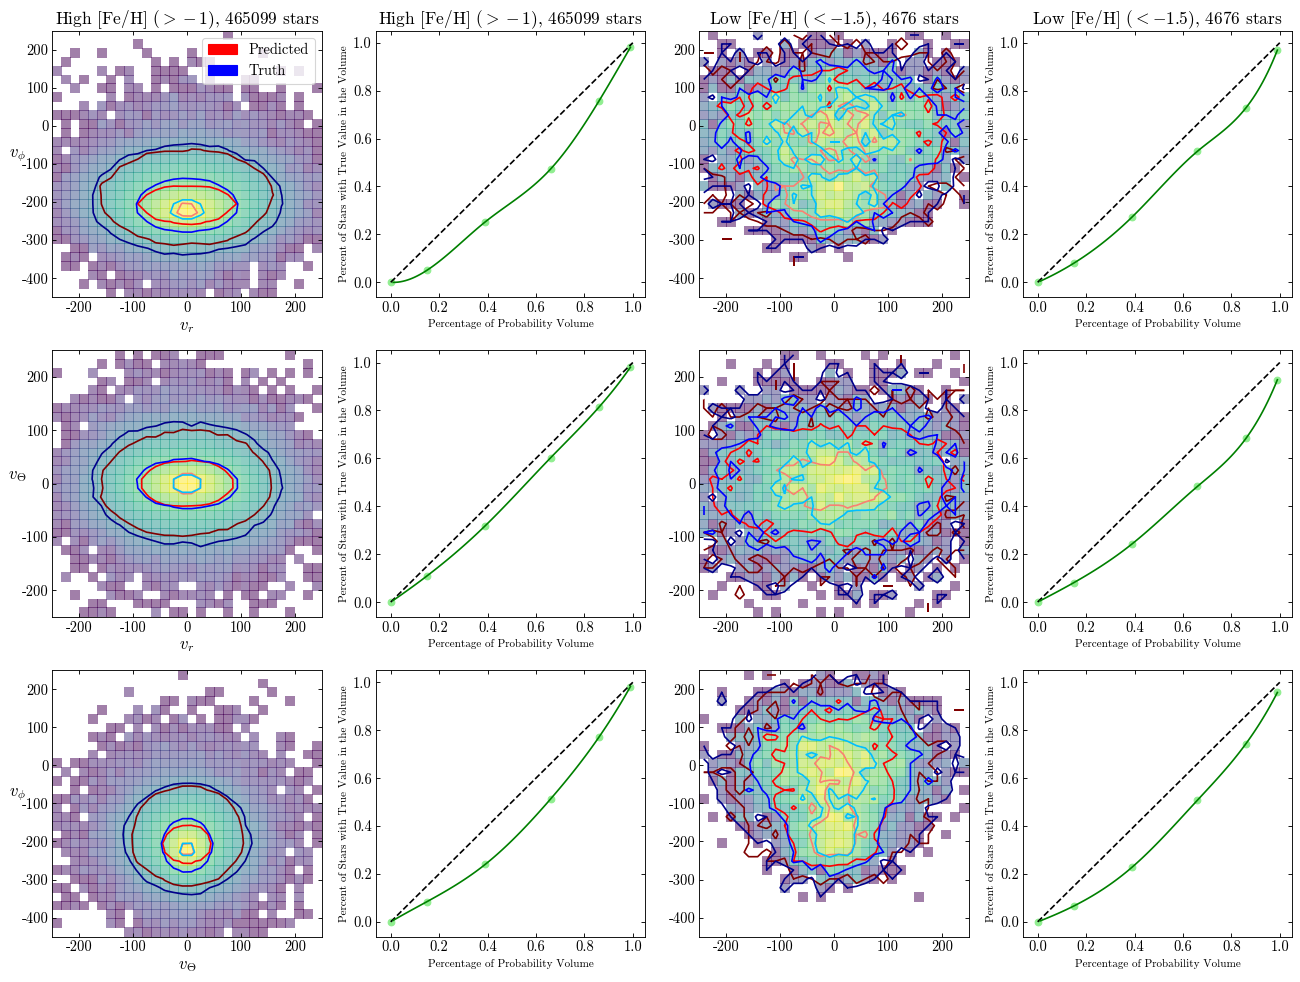

In [9]:
plot_contours(ellipse_df)

In [10]:
def monte_carlo(ellipse_df_full):
    from tqdm import tqdm
    from matplotlib.colors import LogNorm
    y_low = -250
    y_high = 250
    mc_vr_pred_list = []
    mc_pred_list_vr = []
    mc_pred_list_vth = []
    mc_pred_list_vphi = []
    resample_test_list = []
    bin_values_list = []
    min_array = []
    max_array = []
    min_array_r = []
    max_array_r = []
    min_array_th = []
    max_array_th = []
    min_array_phi = []
    max_array_phi = []

    hb_list = []
    hist_list_vr_vphi = []
    hist_list_vr_vth = []
    hist_list_vth_vphi = []
    hex_centers = []

    bin_values_list_r = []
    bin_values_list_th = []
    bin_values_list_phi = []

    N = len((ellipse_df_full['vlos_pred']).values)
    x_range = np.linspace(y_low,y_high,N)
    test_preds =ellipse_df_full[['vlos_pred', 'sigma_los']].to_numpy()
    for mc_i in tqdm(range(0,10)):
        mc_vr_pred = []
        resample_test = []
        for star_i in range(0,len(test_preds)):
            mc_vr_pred.append(np.random.normal(test_preds[star_i,0],test_preds[star_i,1]))

        mc_vr_pred_list.append(mc_vr_pred)
        resample_test_list.append(resample_test)
        n, bins = np.histogram(mc_vr_pred,bins=50,range=(y_low,y_high), density = True)
        n_test_preds, bins_test_preds = np.histogram((ellipse_df_full['vlos_true']).values, bins=50, range=(y_low,y_high))

        plt.figure(2)
        hb = plt.hexbin((ellipse_df_full['vlos_true']).values, mc_vr_pred,gridsize=80, norm = LogNorm(),extent=[-200, 200, -200, 200]);
        hb_list.append(hb.get_array());
        bin_values_list.append(n)

        #now for the coordinate-transformed histograms
        vel_sph_coord = get_coord_transform(ellipse_df_full, np.array(mc_vr_pred).flatten().astype('float'))
        n_r , bins_r = np.histogram(vel_sph_coord[:,0], bins=50, range=(-250,250), density = True)
        n_th , bins_th = np.histogram(vel_sph_coord[:,1], bins=50, range=(-250,250), density = True)
        n_phi , bins_phi = np.histogram(vel_sph_coord[:,2], bins=50, range=(-450,0), density = True)
        bin_values_list_r.append(n_r)
        bin_values_list_th.append(n_th)
        bin_values_list_phi.append(n_phi)
        mc_pred_list_vr.append(vel_sph_coord[:,0])
        mc_pred_list_vth.append(vel_sph_coord[:,1])
        mc_pred_list_vphi.append(vel_sph_coord[:,2])

        hist_vr_vphi, xedges_vr_vphi ,yedges_vr_vphi = np.histogram2d(vel_sph_coord[:,0],vel_sph_coord[:,2],bins = (30,30) ,range=[[-250, 250],[-450, 250]], density = True);
        hist_list_vr_vphi.append(hist_vr_vphi);


        hist_vr_vth, xedges_vr_vth,yedges_vr_vth = np.histogram2d(vel_sph_coord[:,0], vel_sph_coord[:,1],bins = (30,30),range =[[-250, 250],[-250, 250]], density = True);
        hist_list_vr_vth.append(hist_vr_vth);


        hist_vth_vphi, xedges_vth_vphi,yedges_vth_vphi = np.histogram2d(vel_sph_coord[:,1], vel_sph_coord[:,2],bins = (30,30),range=[[-250, 250], [-450, 250]], density = True);
        hist_list_vth_vphi.append(hist_vth_vphi);
        plt.close(2)


    return hist_list_vr_vphi, hist_list_vr_vth, hist_list_vth_vphi

In [11]:
def get_coord_transform(df, train_preds):
    #needs only vr values of train_preds (maybe...need to see what to do about error)

    v_LSR = [11.1, 239.08, 7.25]
    r_LSR = [-8.,0.,0.015]

    sin_theta_gc, sin_phi_gc ,cos_theta_gc, cos_phi_gc= TransformCoords.calc_theta_phi(np.deg2rad(df['ra'].values),np.deg2rad(df['dec'].values),np.deg2rad(df['b'].values),np.deg2rad(df['l'].values), df['parallax'].values ,train_preds.astype(np.float32))
    vr_gc, vth_gc, vphi_gc = TransformCoords.cart_to_galcen(np.deg2rad(df['ra'].values),np.deg2rad(df['dec'].values), np.deg2rad(df['b'].values) ,np.deg2rad(df['l'].values), df['parallax'].values,train_preds.astype(np.float32), df['pmra'].values, df['pmdec'].values,sin_theta_gc, sin_phi_gc, cos_theta_gc, cos_phi_gc)

    vels_sph_pred_train = np.array([vr_gc, vth_gc, vphi_gc]).T
    return vels_sph_pred_train

  0%|          | 0/10 [00:00<?, ?it/s]

(4676, 21)
(465099, 21)


  0%|          | 1640/465099 [00:00<00:28, 16393.10it/s]

(30, 30)
level_i 9.919663199682097e-05


  0%|          | 1651/465099 [00:00<00:28, 16505.33it/s]

0.9952719743538473
level_i 0.00295374013048202


  0%|          | 1651/465099 [00:00<00:28, 16503.33it/s]

0.8940698646954734
level_i 0.010306565934610044


  0%|          | 1646/465099 [00:00<00:28, 16450.68it/s]

0.7207927774516824
level_i 0.021018088297819957


  0%|          | 1644/465099 [00:00<00:28, 16433.43it/s]

0.44913878550588154
level_i 0.04961041940019409


 35%|███▍      | 1630/4676 [00:00<00:00, 16297.14it/s]

0.1970677210658376
(30, 30)
level_i 0.00013530839613242352


 35%|███▌      | 1641/4676 [00:00<00:00, 16404.34it/s]

0.9916595380667237
level_i 0.0008786464945251528


 35%|███▌      | 1646/4676 [00:00<00:00, 16454.05it/s]

0.8468776732249786
level_i 0.0017583387921076632


 35%|███▌      | 1638/4676 [00:00<00:00, 16377.67it/s]

0.6422155688622755
level_i 0.002727427337538898


 35%|███▌      | 1647/4676 [00:00<00:00, 16465.03it/s]

0.34046193327630453
level_i 0.0038757731424539183


  0%|          | 1631/465099 [00:00<00:28, 16305.70it/s]

0.12018819503849444
(30, 30)
level_i 8.843864703812373e-05


  0%|          | 1653/465099 [00:00<00:28, 16528.32it/s]

0.9935282595748433
level_i 0.0025972048339866294


  0%|          | 1644/465099 [00:00<00:28, 16438.37it/s]

0.8769767296855078
level_i 0.012373409668804073


  0%|          | 1630/465099 [00:00<00:28, 16295.39it/s]

0.6804078271507786
level_i 0.04392287708752775


  0%|          | 1666/465099 [00:00<00:27, 16650.61it/s]

0.40950636316139144
level_i 0.06450577230069773


 35%|███▍      | 1636/4676 [00:00<00:00, 16352.45it/s]

0.11731265816525084
(30, 30)
level_i 0.00011287819220392893


 35%|███▍      | 1636/4676 [00:00<00:00, 16359.04it/s]

0.9833190761334474
level_i 0.000745461965770447


 35%|███▍      | 1635/4676 [00:00<00:00, 16342.26it/s]

0.8073139435414884
level_i 0.0017392782899406515


 35%|███▌      | 1651/4676 [00:00<00:00, 16509.46it/s]

0.6122754491017964
level_i 0.0035700413705438655


 35%|███▌      | 1644/4676 [00:00<00:00, 16437.35it/s]

0.36398631308810947
level_i 0.005668463714446883


  0%|          | 1633/465099 [00:00<00:28, 16320.60it/s]

0.13558597091531224
(30, 30)
level_i 0.00011979243433239456


  0%|          | 1630/465099 [00:00<00:28, 16297.30it/s]

0.9943259392086417
level_i 0.0044596300668122


  0%|          | 1647/465099 [00:00<00:28, 16461.03it/s]

0.8848503221894694
level_i 0.022782488582013663


  0%|          | 1641/465099 [00:00<00:28, 16405.63it/s]

0.7122333094674467
level_i 0.09391506284905135


  0%|          | 1654/465099 [00:00<00:28, 16537.26it/s]

0.44444086097798535
level_i 0.10954786022122145


 35%|███▍      | 1632/4676 [00:00<00:00, 16318.34it/s]

0.08451963990462245
(30, 30)
level_i 0.00010808952404693566


 35%|███▍      | 1631/4676 [00:00<00:00, 16303.37it/s]

0.9905902480752781
level_i 0.0009943810119816133


 35%|███▌      | 1645/4676 [00:00<00:00, 16448.33it/s]

0.8712574850299402
level_i 0.002334194266261503


 35%|███▌      | 1656/4676 [00:00<00:00, 16551.81it/s]

0.657185628742515
level_i 0.004215427298976785


 35%|███▌      | 1648/4676 [00:00<00:00, 16478.13it/s]

0.3633447390932421
level_i 0.005641955291697419


100%|██████████| 4676/4676 [00:00<00:00, 16310.88it/s]


0.12040205303678357


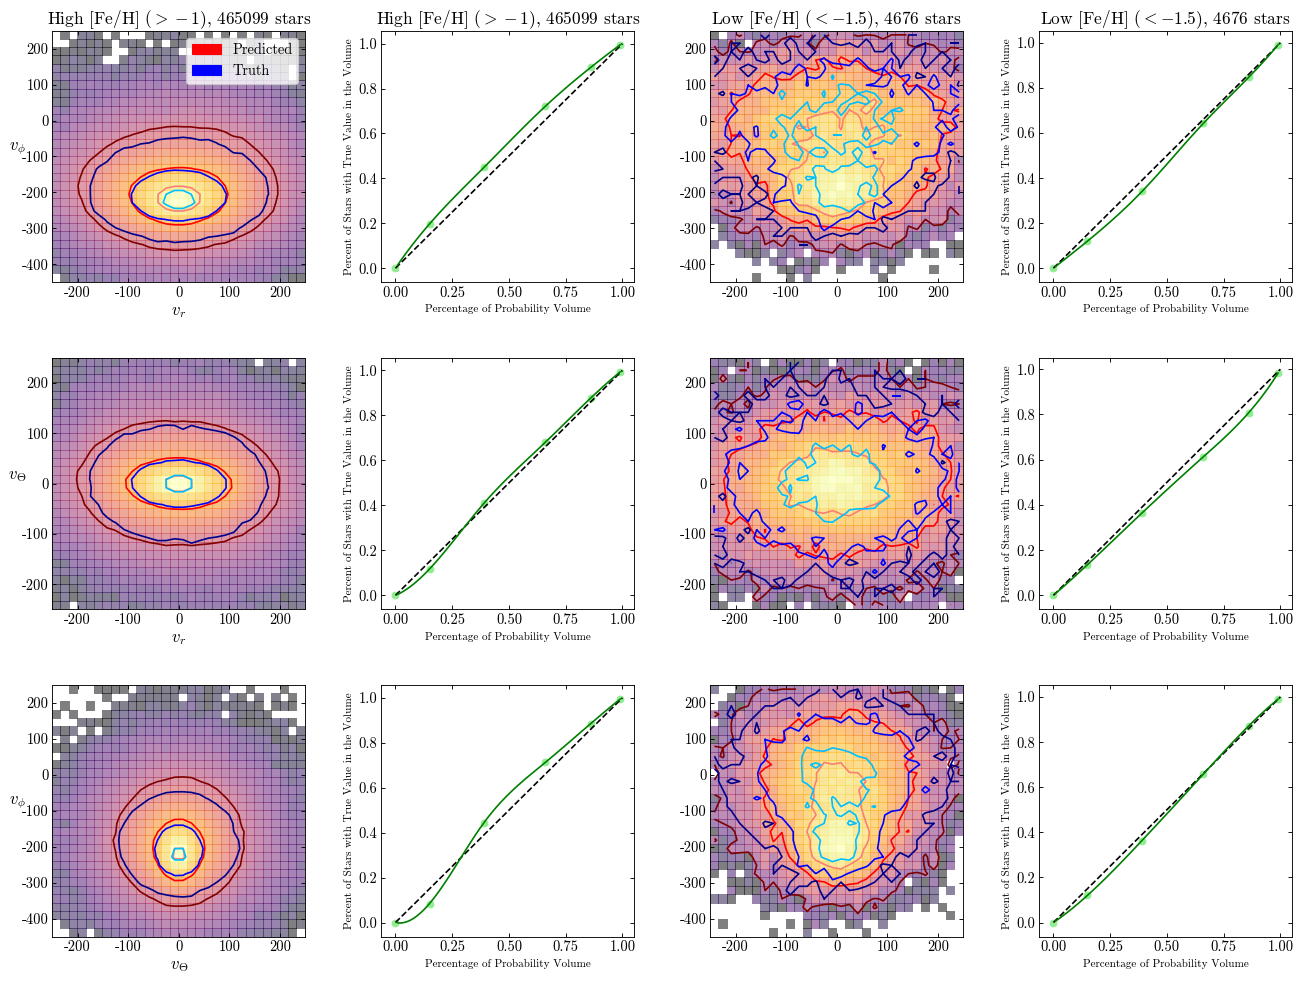

In [12]:
plot_contours_MC(ellipse_df)

(100, 100)


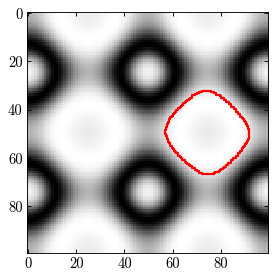

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**2 + np.cos(y)**2)))
print(r.shape)
# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Select the largest contiguous contour
contour = sorted(contours, key=lambda x: len(x))[-1]

# Display the image and plot the contour
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)
X, Y = ax.get_xlim(), ax.get_ylim()
ax.step(contour.T[1], contour.T[0], linewidth=2, c='r')
#print(contour.T[1])
ax.set_xlim(X), ax.set_ylim(Y)
plt.show()

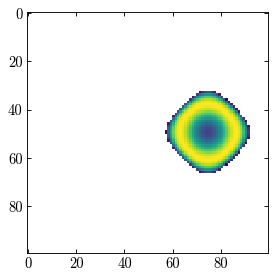

In [14]:
from matplotlib import path
import numpy.ma as ma
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
closed_path = path.Path(np.array([contour.T[1],contour.T[0]]).T)
#print(closed_path)
#print(r.shape[0])
# Get the points that lie within the closed path
idx = np.array([[(i,j) for i in range(r.shape[0])] for j in range(r.shape[1])]).reshape(np.prod(r.shape),2)
mask = closed_path.contains_points(idx).reshape(r.shape)

# Invert the mask and apply to the image
mask = np.invert(mask)
masked_data = ma.array(r.copy(), mask=mask)
plt.imshow(masked_data)
#print(masked_data)


#     from matplotlib import path
#     closed_path = path.Path(np.array([np.round(contoura.allsegs[0][0][:,0]).astype('int'), np.round(contoura.allsegs[0][0][:,1]).astype('int')]).T)
#     contour = np.squeeze(np.round(contoura.allsegs[2]).astype('int'))

#     polygon = np.array(contour)
#     left = np.min(polygon, axis=0)
#     right = np.max(polygon, axis=0)
#     x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
#     y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
#     xv, yv = np.meshgrid(x, y, indexing='xy')
#     points = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))
#     path = matplotlib.path.Path(polygon)
#     mask = path.contains_points(points)
#     mask.shape = xv.shape
#     mesh = ax[1].pcolormesh(xv, yv, mask, alpha = 0.5, cmap = "autumn")
    
#     num_true_in_pred_path = 0
#     num_pred_in_pred_path = 0
#     for star_i in tqdm(range(len(ellipse_df_highmet['vr_true'].values[0:2000]))):
#         if cv2.pointPolygonTest(polygon, (ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i]), False) == 1:
#             num_true_in_pred_path =  num_true_in_pred_path + 1
#             ax[1].scatter(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i], color = "blue", s = 5)
#         else:
#             ax[1].scatter(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i], color = "purple", s = 5)

#         if cv2.pointPolygonTest(polygon, (ellipse_df_highmet['vr_pred'].values[star_i],ellipse_df_highmet['vphi_pred'].values[star_i]), False) == 1:
#             num_pred_in_pred_path =  num_pred_in_pred_path + 1
#     print("num_true_in_pred_path",str(num_true_in_pred_path))
#     print("num_pred_in_pred_path",str(num_pred_in_pred_path))
#     print("ratio_path",str(num_true_in_pred_path/num_pred_in_pred_path))
#     x_coord = [0,0,-163]
#     y_coord = [-200,0,-196]
#     point1 = (0,-200)
#     point2 = (0,0)
#     point3 = (-163,-196)
    
#     result1 = cv2.pointPolygonTest(polygon, point1, False)
#     result2 = cv2.pointPolygonTest(polygon, point2, False)
#     result3 = cv2.pointPolygonTest(polygon, point3, False)
#     print(result1)
#     print(result2)
#     print(result3)
#     n = [result1,result2,result3]